## Transit-oriented development (TOD) degree Measurement with Railway Network

---

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
os.environ['USE_PYGEOS'] = '0'
import helpers as hs
from importlib import reload
import folium
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

---------- Import helpers ----------
--- Transportation Module loaded ---


### Read the distance dataset

---

In [3]:
result_distance = hs.read_distance_csv("data_result/result_distance.csv")
result_distance = pd.DataFrame(result_distance.values, index=result_distance.columns, columns=result_distance.columns)

In [4]:
distance_sum = hs.compute_distance_sum(result_distance)
distance_sum.head()

,sum
CRS3035RES200mN2893400E3763200,176296.654194
CRS3035RES200mN2890000E3762200,134484.732575
CRS3035RES200mN2893400E3762400,161872.358663
CRS3035RES200mN2891800E3763600,169713.93164
CRS3035RES200mN2890800E3763200,155289.718228


In [5]:
node_index = hs.compute_distance_node_index(distance_sum)
# restore the data to csv file
node_index.to_csv("data_result/node_index.csv")
node_index.head()

,node_index
CRS3035RES200mN2893400E3763200,0.486866
CRS3035RES200mN2890000E3762200,0.790941
CRS3035RES200mN2893400E3762400,0.574018
CRS3035RES200mN2891800E3763600,0.524801
CRS3035RES200mN2890800E3763200,0.61917


In [6]:
# node_index = pd.read_csv("data_result/node_index.csv", index_col=0)
# node_index.head()

### plot the graph of node index with railway transportations

---

In [7]:
filosofi_file = "../data/Filosofi2015_carreaux_200m_paris.gpkg"
pgdf = hs.get_POI_cat_on_INSPIRE_grid(filosofi_file)
pgdf['Log'] = pgdf['Log_inc'] + pgdf['Log_av45'] + pgdf['Log_45_70'] + pgdf['Log_70_90'] + pgdf['Log_ap90']

/Users/yubocai/Desktop/Ecole Polytechnique/Internship/CREST/BATO_extension/helpers/scrapping.py:200: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf_pois = ox.geometries_from_place(place, tags, buffer_dist=1000)
/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/osmnx/geometries.py:127: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your query area directly, if desired.
  return features.features_from_place(query, tags, which_result, buffer_dist)
/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/osmnx/features.py:268: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your results directly, if desired.
  gdf_place = geocoder.geocode_to_g

In [8]:
# First create a new column with the node index in pgdf
pgdf["node_index"] = 0

# Then for each IdINSPIRE, we assign the node index
for i in range(len(pgdf)):
    pgdf.iloc[i, -1] = node_index.loc[pgdf.iloc[i, pgdf.columns.get_loc("IdINSPIRE")], "node_index"]

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
idCol = "IdINSPIRE"
weights_by_id_without_transportation = hs.calculate_distanceband_weights(pgdf,idCol=idCol) 

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


### Plot the graph of node index 

---

In [10]:
img_node_index = hs.folium_grid_cat_plot(pgdf, "node_index", zoom_start=12.5, linecolor='maroon',   
                                         linewidth=4,
                                         nodecolor='cyan',
                                         noderadius=3,
                                         op=0.8,)
m_img = hs.fig_save_folium(img_node_index, 'figure/',
                           "img_node_index", width=1100, height=1100, dpi=600)

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute the Place index

---

The **place index** of an AZ is the amenity score per unit of inhabitants. For each type of amenity, we assigned a frequency and a weight. The frequency is determined by the ratio of the number of items in that category $\left(N_p\right)$ to the total number of amenities $(N)$ and the weight is the opposite of the frequency:
\begin{equation}
    f = \frac{N_{p}}{N} \quad \text{and} \quad w_{p}=1-\frac{N_{p}}{N} \quad \text{where $p$ is the category}
\end{equation}
The underlying concept here is that if a particular type of amenity is less abundant in a certain area, its relative importance in that area becomes higher. After performing the calculations, we obtained the weights for each type of facility:

For each AZ, we can compute the amenity score (AS) and place index with the following formula:
\begin{equation}
    AS_{i} = \sum_{p} N_{p} w_{p}  \quad \text{and} \quad  \text{place index}_{i} = \frac{AS_{i}}{\text{inh}_{i}}
\end{equation}
where $p$ is the category, $i$ is the index of AS, and $\text{inh}_{i}$ is the number of inhabitants in the $AZ_{i}$. To facilitate comparison across various case studies, we applied min-max normalization to calculate standardized node and place indices for each study.

In [11]:
pgdf['Inhabitants'] = pgdf['Ind_0_3'] + pgdf['Ind_4_5'] + pgdf['Ind_6_10'] + pgdf['Ind_11_17'] + pgdf['Ind_18_24'] + pgdf['Ind_25_39'] + pgdf['Ind_40_54'] + pgdf['Ind_55_64'] + pgdf['Ind_65_79'] + pgdf['Ind_80p'] 

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
interestVar2 = ['restaurant',
       'culture and art', 'education', 'food_shops', 'fashion_beauty',
       'supply_shops']
for var in interestVar2:
        pgdf[str("weight_" + var)] = pgdf[var].sum()/(pgdf[interestVar2].sum(axis = 1).sum())

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
weight_table = 1 - pgdf[[str("weight_" + var) for var in interestVar2]]
weight_table.head()

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,weight_restaurant,weight_culture and art,weight_education,weight_food_shops,weight_fashion_beauty,weight_supply_shops
IdINSPIRE,,,,,,
CRS3035RES200mN2893400E3763200,0.641828,0.946926,0.965579,0.845934,0.795573,0.80416
CRS3035RES200mN2890000E3762200,0.641828,0.946926,0.965579,0.845934,0.795573,0.80416
CRS3035RES200mN2893400E3762400,0.641828,0.946926,0.965579,0.845934,0.795573,0.80416
CRS3035RES200mN2891800E3763600,0.641828,0.946926,0.965579,0.845934,0.795573,0.80416
CRS3035RES200mN2890800E3763200,0.641828,0.946926,0.965579,0.845934,0.795573,0.80416


In [14]:
# We have the weights for each node index and each type of amenity in the dataset weight_table
# We can compute the Amenity Score for each zone, with the formula:
# Amenity Score = sum(weight_amenity * number_amenity for each type of amenity)

# Import weight data from weight_table
for var in interestVar2:
    pgdf[f"weight_{var}"] = weight_table[f"weight_{var}"]

# Calculate the total Amenity Score (AS) for each AZ (Analysis Zone)
pgdf['AS'] = sum(pgdf[var] * pgdf[f"weight_{var}"] for var in interestVar2)

# Calculate the Place Index for each AZ
pgdf['place_index'] = pgdf['AS']

# Perform Min-Max Normalization on the Place Index
pgdf['place_index'] = (pgdf['place_index'] - pgdf['place_index'].min()) / \
    (pgdf['place_index'].max() - pgdf['place_index'].min())

print(f"Max Place Index: {pgdf['place_index'].max()}")

# Define columns to display
column_to_display = ['Inhabitants', 'AS', 'place_index', 'restaurant',
                     'culture and art', 'education', 'food_shops', 'fashion_beauty',
                     'supply_shops']

# Display the head of the dataframe for the specified columns
pgdf[column_to_display].head()

Max Place Index: 1.0


/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Inhabitants,AS,place_index,restaurant,culture and art,education,food_shops,fashion_beauty,supply_shops
IdINSPIRE,,,,,,,,,
CRS3035RES200mN2893400E3763200,2749.5,8.483172,0.081037,4.0,0.0,1.0,3.0,0.0,3.0
CRS3035RES200mN2890000E3762200,1520.5,42.948061,0.410269,21.0,8.0,0.0,6.0,8.0,13.0
CRS3035RES200mN2893400E3762400,1313.0,0.804160,0.007682,0.0,0.0,0.0,0.0,0.0,1.0
CRS3035RES200mN2891800E3763600,1200.5,0.965579,0.009224,0.0,0.0,1.0,0.0,0.0,0.0
CRS3035RES200mN2890800E3763200,672.0,1.607407,0.015355,1.0,0.0,1.0,0.0,0.0,0.0


In [15]:
data_place_index = pgdf[['place_index']]
data_place_index.to_csv("data_result/place_index.csv")
data_place_index.head()

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,place_index
IdINSPIRE,
CRS3035RES200mN2893400E3763200,0.081037
CRS3035RES200mN2890000E3762200,0.410269
CRS3035RES200mN2893400E3762400,0.007682
CRS3035RES200mN2891800E3763600,0.009224
CRS3035RES200mN2890800E3763200,0.015355


In [24]:
img_place_index = hs.folium_grid_cat_plot(pgdf,"place_index", zoom_start=12.5, linecolor='blue',   
                                         linewidth=4,
                                         nodecolor='orange',
                                         noderadius=3,
                                         op=0.8,)
m_img = hs.fig_save_folium(img_place_index,'figure/', "img_place_index", width=1100, height=1100, dpi=600)

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Statistics Analysis

---

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Correlation coefficient: 0.4925888080350649
Slope: 0.6072559642022091
Intercept: 0.5489128740518976
R-squared: 0.24264373380140605
P-value: 2.3437120590655594e-121
Standard error: 0.024140919638067818


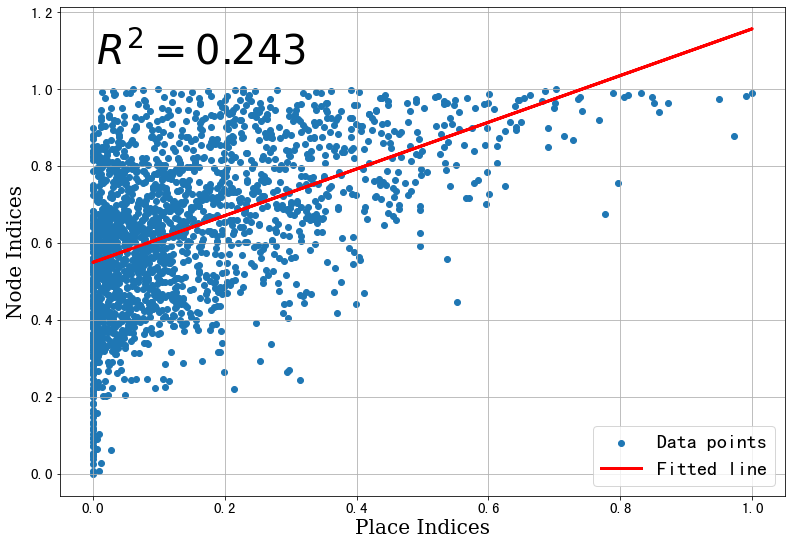

In [17]:
# Calculate the correlation coefficient and R^2 value
correlation = pgdf['place_index'].corr(pgdf['node_index'])
slope, intercept, r_value, p_value, std_err = linregress(pgdf['place_index'], pgdf['node_index'])
r_squared = r_value**2

# Output the results
print(f"Correlation coefficient: {correlation}")
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

# Plot the scatter plot and the fitted line
plt.figure(figsize=(13, 9))
plt.scatter(pgdf['place_index'], pgdf['node_index'], label='Data points')
plt.plot(pgdf['place_index'], intercept + slope * pgdf['place_index'], 'r', label='Fitted line', linewidth=3)
plt.xlabel('Place Indices', fontsize=20, fontfamily='serif')
plt.ylabel('Node Indices', fontsize=20, fontfamily='serif')

# mark the value of R^2
plt.text(0.05, 0.95, f'$R^2 = {r_squared:.3f}$', fontsize=40, ha='left', va='top', transform=plt.gca().transAxes, fontfamily='serif')

plt.legend(fontsize=20, loc='lower right')
plt.tick_params(labelsize=15)
plt.grid(True)
plt.savefig('figure/img_correlation.png', dpi=600, bbox_inches='tight')
plt.show()

In [18]:
correlation_coefficient = pgdf['node_index'].corr(pgdf['place_index'])
slope, intercept, r_value, p_value, std_err = linregress(pgdf['node_index'], pgdf['place_index'])
r_squared = r_value ** 2
slope_difference_degrees = np.degrees(np.arctan(slope)) - 45
mean_node_index = pgdf['node_index'].mean()
mean_place_index = pgdf['place_index'].mean()

# get the output
print(f"Correlation coefficient: {correlation_coefficient}")
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")
print(f"Slope difference (degrees): {slope_difference_degrees}")
print(f"Mean node index: {mean_node_index}")
print(f"Mean place index: {mean_place_index}")

Correlation coefficient: 0.4925888080350649
Slope: 0.3995740644889056
Intercept: -0.10604676769145702
R-squared: 0.24264373380140605
P-value: 2.3437120590655594e-121
Standard error: 0.015884710812112776
Slope difference (degrees): -23.219631798928877
Mean node index: 0.6397456039002978
Mean place index: 0.14957898349789442
